In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

## GDSC dataset

Please note that before running the code, you will need all the GDSC files. They can be found on the drive (https://drive.google.com/drive/u/1/folders/11omvpOttkdZZgv_ppbtcCbojkuVR-D61) or directly on the GDSC website.

In [2]:
NB_DRUGS = 10 #number of best drugs to select
SCORE = "LN_IC50" #other option: "AUC"
SAVE = True #whether to save the final matrix or not
PATH = "data/GDSC/" #where your data is located

#### Cell populations and labels

File which represents how well each cell population reacted to each drug. 

1. How is the drug measured?

    a. **IC50:** describes the concentration of an inhibitor that results in a half-maximal inhibition of a response (i.e. the concentration that reduces a response to 50% of its maximum). That maximum response being inhibited is due to the action of something else (typically an agonist for the receptor of interest). Maximum IC50 = 8. Minimum IC50 = 0. 
    
    IC50 is obtained by plotting a measure of the cell death rate vs the concentration of the drug. IC50 is expressed as a concentration so the higher the concentration of drug needed to kill the cell line the more resistant that cell line is. If the IC50 is very low then the concentration (or amount) of drug needed to kill the cell line is also very low which means the cell line is more sensitive. Typically you get a S curve or sigmoidal curve. IC50 is the middle point of the sigmoidal curve. The threshold for calling a drug sensitive/resistant changes depending upon the IC50 value and we need to see how the sigmoidal curve behaves.
    
    d.	**ActArea:** "*Sensitivity was assayed by measuring cellular ATP levels as a surrogate  for cell number and growth. Raw data were merged with assay metadata, and percent-viability scores were calculated relative to DMSO controls, after which concentration-response curves were fit for percent viability. The areas under percent-viability curves were computed and used as the measure of sensitivity*". In one paper, the limit was set to **0.8 SD**. Sensitive cell lines were the ones with an activity area at least 0.8 SD above the mean. Resistant cell lines had an activity area at least 0.8 SD below the mean. All other samples were discared.
    


In [3]:
conversion = pd.read_excel(PATH + "GDSC_CCLE_conversion.xlsx")[["GDSC1000 cosmic id","GDSC1000 name","CCLE name"]]
conversion.head()

,GDSC1000 cosmic id,GDSC1000 name,CCLE name
0,906800,697,697_HAEMATOPOIETIC_AND_LYMPHOID_TISSUE
1,687452,5637,5637_URINARY_TRACT
2,924100,22RV1,22RV1_PROSTATE
3,910924,23132-87,NaN
4,687561,42-MG-BA,42MGBA_CENTRAL_NERVOUS_SYSTEM


In [4]:
responses = pd.read_excel(PATH + "Fitted_dose_response.xlsx")
responses.head()

,DATASET_VERSION,IC50_RESULTS_ID,COSMIC_ID,CELL_LINE_NAME,DRUG_ID,DRUG_NAME,PUTATIVE_TARGET,MAX_CONC_MICROMOLAR,MIN_CONC_MICROMOLAR,LN_IC50,AUC,RMSE,Z_SCORE
0,17.3,1,683665,MC-CAR,1,Erlotinib,EGFR,2.0,0.007812,2.453524,0.982610,0.021678,-0.015505
1,17.3,1482,684055,ES3,1,Erlotinib,EGFR,2.0,0.007812,3.376592,0.985169,0.029915,0.779999
2,17.3,1791,684057,ES5,1,Erlotinib,EGFR,2.0,0.007812,3.614664,0.983207,0.031201,0.985170
3,17.3,2177,684059,ES7,1,Erlotinib,EGFR,2.0,0.007812,3.223394,0.984574,0.093857,0.647971
4,17.3,2754,684062,EW-11,1,Erlotinib,EGFR,2.0,0.007812,2.486405,0.946034,0.087280,0.012832


In [5]:
#Information

print("Number of different drugs: ",len(responses["DRUG_NAME"].unique()))
print("Number of different cell lines: ", len(responses["CELL_LINE_NAME"].unique()))
print("Total number of tests: ", len(responses.index))
print("Number of tests and cells per drug compounds:")
response_summary = responses.groupby(["DRUG_NAME"])["CELL_LINE_NAME"].agg(['count','nunique']).sort_values(["count"], ascending = False)
response_summary.rename(index = str, columns = {'count': "Number of tests", "nunique" : 'Number of unique cell populations'}, inplace = True)
display(response_summary)

Number of different drugs:  251
Number of different cell lines:  1065
Total number of tests:  224202
Number of tests and cells per drug compounds:


,Number of tests,Number of unique cell populations
DRUG_NAME,,
Avagacestat,1934,1043
UNC0638,1930,1038
AKT inhibitor VIII,1913,998
JQ1,1881,1040
CHIR-99021,1879,1040
AZD6482,1864,1038
Bicalutamide,1830,1034
Afatinib,1825,985
PLX-4720,1824,985


In [6]:
#SELECT THE BEST DRUGS

selected_drugs = response_summary.index[:NB_DRUGS].values.tolist() #select the drugs
best_responses = responses[responses["DRUG_NAME"].isin(selected_drugs)] #filter the responses df to keep only the ones of selected drugs
best_responses = pd.merge(left = best_responses, right = conversion, how = 'left', left_on = 'COSMIC_ID', right_on = "GDSC1000 cosmic id") #add the corresponding CCLE names
best_responses = best_responses.drop(labels = ["DATASET_VERSION", "IC50_RESULTS_ID", "PUTATIVE_TARGET","MAX_CONC_MICROMOLAR", "MIN_CONC_MICROMOLAR", "RMSE", "Z_SCORE", "GDSC1000 cosmic id", "GDSC1000 name"], axis = 1)
best_responses

,COSMIC_ID,CELL_LINE_NAME,DRUG_ID,DRUG_NAME,LN_IC50,AUC,CCLE name
0,683665,MC-CAR,150,Bicalutamide,1.922705,0.985136,NaN
1,683667,PFSK-1,150,Bicalutamide,2.736094,0.984795,NaN
2,684052,A673,150,Bicalutamide,2.145978,0.988013,A673_BONE
3,684055,ES3,150,Bicalutamide,2.693776,0.984989,NaN
4,684057,ES5,150,Bicalutamide,2.945234,0.983207,NaN
5,684059,ES7,150,Bicalutamide,2.032562,0.975121,NaN
6,684062,EW-11,150,Bicalutamide,2.836104,0.973420,NaN
7,684072,SK-ES-1,150,Bicalutamide,2.441425,0.980461,SKES1_BONE
8,684681,NCI-H1395,150,Bicalutamide,3.483724,0.981967,NaN
9,687448,COLO-829,150,Bicalutamide,3.283679,0.972378,NaN


In [7]:
print("Number of elements before dropping missing values", len(best_responses.index))
best_responses = best_responses.dropna(axis = 0)
print("Number of elements after dropping missing values", len(best_responses.index))
best_responses

Number of elements before dropping missing values 18696
Number of elements after dropping missing values 7196


,COSMIC_ID,CELL_LINE_NAME,DRUG_ID,DRUG_NAME,LN_IC50,AUC,CCLE name
2,684052,A673,150,Bicalutamide,2.145978,0.988013,A673_BONE
7,684072,SK-ES-1,150,Bicalutamide,2.441425,0.980461,SKES1_BONE
10,687452,5637,150,Bicalutamide,2.294547,0.989483,5637_URINARY_TRACT
11,687455,RT4,150,Bicalutamide,2.910067,0.987345,RT4_URINARY_TRACT
12,687457,SW780,150,Bicalutamide,1.686112,0.959700,SW780_URINARY_TRACT
13,687459,TCCSUP,150,Bicalutamide,2.004850,0.964950,TCCSUP_URINARY_TRACT
17,687561,42-MG-BA,150,Bicalutamide,2.796803,0.985534,42MGBA_CENTRAL_NERVOUS_SYSTEM
18,687562,8-MG-BA,150,Bicalutamide,2.360374,0.987936,8MGBA_CENTRAL_NERVOUS_SYSTEM
19,687563,A172,150,Bicalutamide,2.553152,0.988687,A172_CENTRAL_NERVOUS_SYSTEM
20,687568,GB-1,150,Bicalutamide,2.621587,0.976243,GB1_CENTRAL_NERVOUS_SYSTEM


In [8]:
final_response_matrix = best_responses.pivot_table(index = "CCLE name", columns = "DRUG_NAME", values = SCORE)
if SAVE:
    final_response_matrix.to_csv(PATH + 'final_response_matrix.csv')
final_response_matrix

DRUG_NAME,AKT inhibitor VIII,AZD6482,Afatinib,Avagacestat,Bicalutamide,CHIR-99021,JQ1,Olaparib,PLX-4720,UNC0638
CCLE name,,,,,,,,,,
22RV1_PROSTATE,1.179495,3.191798,3.292738,3.669544,3.946671,3.615210,0.564080,4.378780,4.941684,1.804188
42MGBA_CENTRAL_NERVOUS_SYSTEM,2.560047,0.914375,3.222914,4.204779,3.703328,2.902907,1.430843,2.445944,4.973607,1.815938
5637_URINARY_TRACT,2.786479,2.929412,0.755066,4.129942,3.295490,3.352622,0.502312,2.520693,3.131749,3.185163
639V_URINARY_TRACT,2.761992,0.879081,1.705377,4.070210,3.118583,3.304297,-0.583141,2.276665,4.210108,3.568516
697_HAEMATOPOIETIC_AND_LYMPHOID_TISSUE,0.104100,1.056752,1.704682,3.337629,2.731476,1.954022,0.025710,0.910062,2.004732,1.417490
769P_KIDNEY,2.633483,1.700658,0.188483,4.035776,3.636013,0.916625,0.452066,2.196797,4.232001,2.550655
786O_KIDNEY,0.563289,0.358750,3.230017,1.579782,3.336285,2.701577,-0.023548,3.081139,3.730594,1.888016
8305C_THYROID,3.929096,1.771745,3.220461,3.789886,3.771260,3.665484,0.635794,4.393126,1.535690,4.883089
8505C_THYROID,3.003603,2.647841,3.336808,4.615969,2.736399,2.104159,1.045843,2.746522,3.797718,1.958606


In [9]:
print("Total number of cell populations for each drug:")
display(final_response_matrix.count(axis = 0))

Total number of cell populations for each drug:


DRUG_NAME
AKT inhibitor VIII    372
AZD6482               385
Afatinib              378
Avagacestat           386
Bicalutamide          385
CHIR-99021            386
JQ1                   386
Olaparib              380
PLX-4720              378
UNC0638               385
dtype: int64

In [10]:
print("How many NaN values do we have per drug compound ?")
display(pd.DataFrame(final_response_matrix.isnull().sum(axis = 0)).T)
print("Total number of missing values: ", final_response_matrix.isnull().sum().sum())

How many NaN values do we have per drug compound ?


DRUG_NAME,AKT inhibitor VIII,AZD6482,Afatinib,Avagacestat,Bicalutamide,CHIR-99021,JQ1,Olaparib,PLX-4720,UNC0638
0,15,2,9,1,2,1,1,7,9,2


Total number of missing values:  49


There are also other datasets provided by GDSC.

In [11]:
drugs = pd.read_csv(PATH + "Drugs.csv") #provides information on the different drugs
drugs.head()

,drug_id,Name,Synonyms,Targets,Target pathway,PubCHEM,Sample Size,Count
0,1242,(5Z)-7-Oxozeaenol,"5Z-7-Oxozeaenol, LL-Z1640-2",TAK1,"Other, kinases",9863776,945,266
1,179,5-Fluorouracil,5-FU,Antimetabolite (DNA & RNA),Other,3385,968,266
2,86,A-443654,KIN001-139,"AKT1, AKT2, AKT3",PI3K/MTOR signaling,10172943,425,266
3,55,A-770041,KIN001-111,"LCK, FYN","Other, kinases",9549184,426,266
4,1001,AICA Ribonucleotide,"AICAR, N1-(b-D-Ribofuranosyl)-5-aminoimidazole...",AMPK agonist,Metabolism,65110,872,266


In [12]:
cells = pd.read_csv(PATH + "Cells.csv") #provides information on the different cell populations 
cells.head()

,,COSMIC_ID,Name,COSMIC_ID.1,Tissue,Tissue sub-type,Count
1287381,201T,SIDM00055,1287381,LUAD,lung,lung_NSCLC_adenocarcinoma,1065
924100,22RV1,SIDM00499,924100,PRAD,urogenital_system,prostate,1065
910924,23132-87,SIDM00980,910924,STAD,digestive_system,stomach,1065
687561,42-MG-BA,SIDM00982,687561,GBM,nervous_system,glioma,1065
1287706,451Lu,SIDM01240,1287706,SKCM,skin,melanoma,1065


In [13]:
features = pd.read_csv(PATH + "Features.csv") #provides information on the different types of alterations
features.head()

,feature_id,Name,Type,Known Driver Genes (cna only),Count
0,1,ABCB1_mut,coding variant,NaN,659
1,2,ABL2_mut,coding variant,NaN,659
2,3,ACACA_mut,coding variant,NaN,659
3,4,ACVR1B_mut,coding variant,NaN,659
4,5,ACVR2A_mut,coding variant,NaN,659


### Loading the old mutation database

In [14]:
alterations = pd.read_csv("data/Alterations.txt", sep  = '\t').set_index('Description').transpose()
alterations.head()

Description,PLCH2_mut,UBE4B_mut,ADGRB2_mut,ZSCAN20_mut,SZT2_mut,MOB3C_mut,ZFYVE9_mut,ST6GALNAC3_mut,TCHH_mut,HRNR_mut,...,HNRNPDL_del,DMTF1_del,PPP4R1_del,CDH1_del,SLC12A6_del,PTBP3_del,KCNE2_del,DGCR2_del,CASP8AP2_del,SCO2_del
127399_SOFT_TISSUE,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
22RV1_PROSTATE,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
A204_SOFT_TISSUE,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
A253_SALIVARY_GLAND,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
A427_LUNG,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [15]:
ML_matrix = alterations.merge(final_response_matrix[['Avagacestat']], left_index = True, right_index = True).dropna(axis = 0)
ML_matrix.head()

,PLCH2_mut,UBE4B_mut,ADGRB2_mut,ZSCAN20_mut,SZT2_mut,MOB3C_mut,ZFYVE9_mut,ST6GALNAC3_mut,TCHH_mut,HRNR_mut,...,DMTF1_del,PPP4R1_del,CDH1_del,SLC12A6_del,PTBP3_del,KCNE2_del,DGCR2_del,CASP8AP2_del,SCO2_del,Avagacestat
22RV1_PROSTATE,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.669544
A204_SOFT_TISSUE,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.253932
A253_SALIVARY_GLAND,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.100926
A673_BONE,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.382341
ALLSIL_HAEMATOPOIETIC_AND_LYMPHOID_TISSUE,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,2.998315


Quick look at the distribution.

C:\Users\Asus\Anaconda3\envs\data-x\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


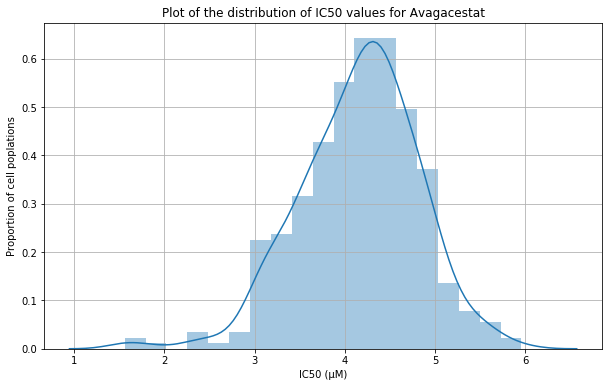

In [16]:
fig = plt.figure(figsize = (10,6))
sns.distplot(ML_matrix[["Avagacestat"]])
plt.title("Plot of the distribution of IC50 values for Avagacestat")
plt.xlabel("IC50 (µM)")
plt.ylabel("Proportion of cell poplations")
plt.grid(True);

Very rough categorisation: everything that's above the mean + 0.5 $\times$ the standard deviation (high IC50) is classified as "resistant" wheras eveything below the mean - 0.5 $\times$ the standard deviation is classified at "sensitive". Everything that is in the middle is discarded. This is not optimal for a number of reasons: (1) the threshold was chosen somewhat arbitrarily and (2) a lot of data is lost. It will have to be optimized in the future. A potential alternative could be to consider the problem as a three classes classification. **Could we consider the median instead of the mean?**

In [17]:
print("The lower threshold used here is the mean minus half the standard deviation = ", np.mean(ML_matrix["Avagacestat"])- 0.5*np.std(ML_matrix["Avagacestat"]))
print("The upper threshold used here is the mean plus half the standard deviation = ", np.mean(ML_matrix["Avagacestat"])+ 0.5*np.std(ML_matrix["Avagacestat"]))
ML_matrix["Response"] = pd.cut(ML_matrix["Avagacestat"], [np.min(ML_matrix["Avagacestat"]), np.mean(ML_matrix["Avagacestat"]) - 0.5*np.std(ML_matrix["Avagacestat"]), np.mean(ML_matrix["Avagacestat"]) + 0.5*np.std(ML_matrix["Avagacestat"]), np.max(ML_matrix["Avagacestat"])], labels = ["sensitive","medium", "resistant"])
ML_matrix = ML_matrix.drop(["Avagacestat"], axis = 1)
ML_matrix

The lower threshold used here is the mean minus half the standard deviation =  3.827363722698614
The upper threshold used here is the mean plus half the standard deviation =  4.484489621948905


,PLCH2_mut,UBE4B_mut,ADGRB2_mut,ZSCAN20_mut,SZT2_mut,MOB3C_mut,ZFYVE9_mut,ST6GALNAC3_mut,TCHH_mut,HRNR_mut,...,DMTF1_del,PPP4R1_del,CDH1_del,SLC12A6_del,PTBP3_del,KCNE2_del,DGCR2_del,CASP8AP2_del,SCO2_del,Response
22RV1_PROSTATE,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,sensitive
A204_SOFT_TISSUE,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,medium
A253_SALIVARY_GLAND,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,medium
A673_BONE,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,sensitive
ALLSIL_HAEMATOPOIETIC_AND_LYMPHOID_TISSUE,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,sensitive
CORL23_LUNG,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,sensitive
DOV13_OVARY,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,resistant
G401_SOFT_TISSUE,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,medium
G402_SOFT_TISSUE,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,medium
HEL9217_HAEMATOPOIETIC_AND_LYMPHOID_TISSUE,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,sensitive


In [18]:
#Drop all the "medium" classes

ML_matrix = ML_matrix.drop(ML_matrix[ML_matrix["Response"] == "medium"].index) 
ML_matrix

,PLCH2_mut,UBE4B_mut,ADGRB2_mut,ZSCAN20_mut,SZT2_mut,MOB3C_mut,ZFYVE9_mut,ST6GALNAC3_mut,TCHH_mut,HRNR_mut,...,DMTF1_del,PPP4R1_del,CDH1_del,SLC12A6_del,PTBP3_del,KCNE2_del,DGCR2_del,CASP8AP2_del,SCO2_del,Response
22RV1_PROSTATE,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,sensitive
A673_BONE,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,sensitive
ALLSIL_HAEMATOPOIETIC_AND_LYMPHOID_TISSUE,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,sensitive
CORL23_LUNG,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,sensitive
DOV13_OVARY,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,resistant
HEL9217_HAEMATOPOIETIC_AND_LYMPHOID_TISSUE,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,sensitive
KYSE140_OESOPHAGUS,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,resistant
NCIH1048_LUNG,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,sensitive
NCIH1092_LUNG,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,resistant
SAOS2_BONE,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,resistant


In [19]:
# Looking at class balance

ML_matrix.dropna(axis = 0)
print("Number of resistant cells: ", len(ML_matrix[ML_matrix["Response"] == "resistant"]))
print("Number of sensitive cells: ", len(ML_matrix[ML_matrix["Response"] == "sensitive"]))
print("Total number of cells: ", len(ML_matrix.index))

Number of resistant cells:  119
Number of sensitive cells:  111
Total number of cells:  231


In [20]:
print("Cell population with no response: ", str(ML_matrix[(ML_matrix["Response"] != "resistant") & (ML_matrix["Response"] != "sensitive")].index[0]))

Cell population with no response:  RPMI8402_HAEMATOPOIETIC_AND_LYMPHOID_TISSUE


In [24]:
ML_matrix.drop("RPMI8402_HAEMATOPOIETIC_AND_LYMPHOID_TISSUE", axis = 0, inplace = True)
if SAVE:
    ML_matrix.to_csv(PATH + 'ML_matrix.csv')
ML_matrix.head()

,PLCH2_mut,UBE4B_mut,ADGRB2_mut,ZSCAN20_mut,SZT2_mut,MOB3C_mut,ZFYVE9_mut,ST6GALNAC3_mut,TCHH_mut,HRNR_mut,...,DMTF1_del,PPP4R1_del,CDH1_del,SLC12A6_del,PTBP3_del,KCNE2_del,DGCR2_del,CASP8AP2_del,SCO2_del,Response
22RV1_PROSTATE,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,sensitive
A673_BONE,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,sensitive
ALLSIL_HAEMATOPOIETIC_AND_LYMPHOID_TISSUE,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,sensitive
CORL23_LUNG,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,sensitive
DOV13_OVARY,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,resistant


Let's get rid of all the genes with a variance smaller than 0.1. This will significantly reduce the size of the dataframe and make it easier to work with. 

In [29]:
variance = ML_matrix.var(axis = 0)
reduced_ML_matrix = ML_matrix.loc[:,variance[variance > 0.1].index]
reduced_ML_matrix["Response"] = ML_matrix["Response"]

In [30]:
if SAVE:
    reduced_ML_matrix.to_csv(PATH + 'Reduced_ML_matrix.csv')
reduced_ML_matrix.head()

,SZT2_mut,TCHH_mut,HRNR_mut,FLG2_mut,BAZ2B_mut,SCN9A_mut,ANK2_mut,RP1L1_mut,ABCA2_mut,EP400_mut,...,SERPINB7_del,TNFRSF11A_del,SERPINB12_del,SERPINB11_del,CTDP1_del,DSEL_del,SOCS6_del,VPS4B_del,ZNF516_del,Response
22RV1_PROSTATE,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,sensitive
A673_BONE,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,sensitive
ALLSIL_HAEMATOPOIETIC_AND_LYMPHOID_TISSUE,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,sensitive
CORL23_LUNG,0.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,sensitive
DOV13_OVARY,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,resistant
